---
author: Martiño Ríos García
date: 2024-05-17
title: 4 | Choosing the learning paradigm
keep-ipynb: True
---

The objective of this book is to illustrate with a practical example how to decide which learning paradigm is better for each application. To illustrate the process, some information about chemical reactions will be extracted from paragraphs of text.

## First steps

Choosing the learning paradigm should begin trying some models with a general pre-training. For this practical case, the first model to test is the very recent Llama-3 8B model with a zero and one-shot prompts.

We will start by importing all the packages needed.

In [1]:
import os
# Hide the Wandb login
os.environ["WANDB_SILENT"]="true"

In [2]:
import json 
import wandb
from dotenv import load_dotenv

import torch
from datasets import (
    load_dataset,
)
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from peft import (
    LoraConfig,
)
from trl import (
    SFTTrainer,
    DataCollatorForCompletionOnlyLM,
)
from evaluate import load
import litellm
from litellm import completion
from litellm.caching import Cache
from statistics import mean
import numpy as np 
import matplotlib.pyplot as plt 

To continue we will allow for the caching of `LiteLLM`. Additionally, we will import all environment variables. 

::: {.column-margin}
Note that using the environment variables is the safest way of keeping personal API keys secret.
:::

In [3]:
litellm.cache = Cache()
load_dotenv(".env", override=True)

True

## First model and dataset

As starting model, we will try the Llama-3 8B model. We will call this model through the *Groq API*, which allows performing fast inference with several open-source models.

::: {.column-margin}
**Groq** is a provider of some of the most popular open-source models such as Llama or Mixtral models with a high inference speed. To use the Groq API, it also needed to add the *GROQ_API_KEY* to the *.env* file.
:::

In [4]:
base_model = "groq/llama3-8b-8192"

The dataset used in this tutorial is the one used in Ai et al.'s [@Ai_2024] recent work, which contains data about chemical reactions. The dataset contains 100K reaction procedure—ORD JSON pairs. 

::: {.column-margin}
**ORD** stands for *Open Reaction Database* schema, a comprehensive data structure specially designed to describe all the elements involved in chemical reactions.
:::


::: {.callout-tip title="Download data" collapse="true"}

To obtain the data, the best way is to install the *GitHub* repository of the Ai et al. work and take from there. To do so, run the following commands: 

```
!git clone https://github.com/qai222/LLM_organic_synthesis.git
!cp LLM_organic_synthesis/workplace_data/datasets/USPTO-n100k-t2048_exp1.7z .
!7za x USPTO-n100k-t2048_exp1.7z
!cp USPTO-n100k-t2048_exp1/*.json .
!rm -rf USPTO-n100k-t2048_exp1/ USPTO-n100k-t2048_exp1.7z LLM_organic_synthesis
```
This will leave four *.json* files in your current directory that contain all the data used here.
:::

In [5]:
test_ds_path = "test.json"
test_dataset = load_dataset("json", data_files=test_ds_path, split="train")
test_dataset = test_dataset.shuffle(seed=42).select(range(100))
test_dataset

Dataset({
    features: ['output', 'instruction'],
    num_rows: 100
})

::: {.column-margin}
Note that we only selected 100 samples from the test set. This will be enough for the demo shown here.
:::

In [6]:
test_dataset[0]

{'output': '{"inputs": {"m1": {"components": [{"identifiers": [{"type": "NAME", "value": "4-nitrobenzyl (1R,3R,5R,6S)-6-((1R)-1-hydroxyethyl)-1-methyl-2-oxo-1-carbapenam-3-carboxylate"}], "amount": {"mass": {"value": 743.0, "units": "MILLIGRAM"}}, "reaction_role": "REACTANT"}]}, "m2": {"components": [{"identifiers": [{"type": "NAME", "value": "2-(tri-n-butylstannyl)-7-trifluoromethylthioimidazo[5,1-b]thiazole"}], "amount": {"mass": {"value": 1.06, "units": "GRAM"}}, "reaction_role": "REACTANT"}]}}, "conditions": {"conditions_are_dynamic": true}, "outcomes": [{"products": [{"identifiers": [{"type": "NAME", "value": "4-nitrobenzyl (1S,5R,6S)-6-((1R)-1-hydroxyethyl)-1-methyl-2-(7-trifluoromethylthioimidazo[5,1-b]thiazol-2-yl)-1-carbapen-2-em-3-carboxylate"}], "measurements": [{"type": "AMOUNT", "details": "MASS", "amount": {"mass": {"value": 172.0, "units": "MILLIGRAM"}}}], "reaction_role": "PRODUCT"}]}]}',
 'instruction': 'Below is a description of an organic reaction. Extract informatio

::: {.column-margin}
Note that the output comes in JSON format. For this simple example we are not going to constrain the output to JSON format. However, to ensure good results this constraining must be done. Deep explanation and examples about the options and how to constrain the output are provided in the chapter and its notebook "*Constrained decoding and enforcing valid outputs*".
:::

This dataset is very big. Therefore, we will only take 100 samples from the test set used in the article mentioned above for our test set.

## Prompt and Inference

We define a simple prompt template. The prompt contains a simple *system* part (named as *PREFIX*) where the role and task of the model is defined as well as the example used only for the 1-shot prompt. 
Additionally, the prompt has a *user* prompt where the reaction instruction will be provided.

In [7]:
PREFIX = """You are a helpful scientific assistant. Your task is to extract information about organic reactions. {shot}"""
SUFFIX = """\n\n{sample}\n\n"""
SHOT = """
One example is provided to you to show how to perform the task:

### Procedure:\nA suspension of 8 g of the product of Example 7 and 0.4 g of DABCO in 90 ml of xylenes were heated under N2 at 130\u00b0-135\u00b0 C. while 1.8 ml of phosgene was added portionwise at a rate to maintain a reflux temperature of about 130\u00b0-135\u00b0 C. The mixture was refluxed an additional two hours, cooled under N2 to room temperature, filtered, and the filtrate was concentrated in vacuo to yield 6.9 g of the subject compound as a crude oil.\n\n
### ORD JSON:\n{\"inputs\": {\"m1_m2_m4\": {\"components\": [{\"identifiers\": [{\"type\": \"NAME\", \"value\": \"product\"}], \"amount\": {\"mass\": {\"value\": 8.0, \"units\": \"GRAM\"}}, \"reaction_role\": \"REACTANT\"}, {\"identifiers\": [{\"type\": \"NAME\", \"value\": \"DABCO\"}], \"amount\": {\"mass\": {\"value\": 0.4, \"units\": \"GRAM\"}}, \"reaction_role\": \"REACTANT\"}, {\"identifiers\": [{\"type\": \"NAME\", \"value\": \"xylenes\"}], \"amount\": {\"volume\": {\"value\": 90.0, \"units\": \"MILLILITER\"}}, \"reaction_role\": \"SOLVENT\"}]}, \"m3\": {\"components\": [{\"identifiers\": [{\"type\": \"NAME\", \"value\": \"phosgene\"}], \"amount\": {\"volume\": {\"value\": 1.8, \"units\": \"MILLILITER\"}}, \"reaction_role\": \"REACTANT\"}]}}, \"conditions\": {\"temperature\": {\"control\": {\"type\": \"AMBIENT\"}}, \"conditions_are_dynamic\": true}, \"workups\": [{\"type\": \"ADDITION\", \"details\": \"was added portionwise at a rate\"}, {\"type\": \"TEMPERATURE\", \"details\": \"to maintain a reflux temperature of about 130\\u00b0-135\\u00b0 C\"}, {\"type\": \"TEMPERATURE\", \"details\": \"The mixture was refluxed an additional two hours\", \"duration\": {\"value\": 2.0, \"units\": \"HOUR\"}}, {\"type\": \"FILTRATION\", \"details\": \"filtered\"}, {\"type\": \"CONCENTRATION\", \"details\": \"the filtrate was concentrated in vacuo\"}], \"outcomes\": [{\"products\": [{\"identifiers\": [{\"type\": \"NAME\", \"value\": \"subject compound\"}], \"measurements\": [{\"type\": \"AMOUNT\", \"details\": \"MASS\", \"amount\": {\"mass\": {\"value\": 6.9, \"units\": \"GRAM\"}}}], \"reaction_role\": \"PRODUCT\"}]}]}
\n
"""

::: {.column-margin}
**PREFIX** is supposed to be content of the system prompt.
**SUFFIX** is the user prompt.
**SHOT** is the 1-shot prompt that will be added to the system prompt when used.
:::

To continue, we loop all over the dataset two times, one for each type of prompt (zero and one-shot). For each dataset sample, we format the prompt to include the procedure-output schema pairs using the template defined in the previous cell. In addition, we also predict using the model and store those predictions for future evaluation.

In [8]:
shots = ["0-shot", "1-shot"]
results_llama = {}

# Start by looping over the shots
for s in shots:
    predictions = []
    references = []

# Loop over all the samples of the dataset
    for t in test_dataset:
        instruction = t["instruction"]
        output = t["output"]
        # Format the prompt following OpenAI"s prompting guidelines
        if s == "0-shot":
            shot = ""
        else:
            shot = SHOT
        system = PREFIX.format(shot=shot)
        user = SUFFIX.format(sample=instruction)
        prompt = [
            {"role": "system", "content": system},
            {"role": "user", "content": user},
        ]
        # Do the completion using Groq API through LiteLLM
        pred = (
            completion(
                model=base_model,
                messages=prompt,
                caching=True,
                temperature=0,
            )
            .choices[0]
            .message.content
        )
        # Save the predictions and the references for later evaluation
        references.append(output)
        predictions.append(pred)

    results_llama[s] = {
        "predictions": predictions,
        "references": references,
    }

::: {.column-margin}
The beauty of *LiteLLM*is that it allows to do completions for a bunch of models by different providers using for all the [*OpenAI* prompt completions schema](https://platform.openai.com/docs/api-reference/chat/create):
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}

This format of completions is probably the most extended one, and is really intuitive.
:::

After generating the predictions, it's essential to evaluate them. We will initially use BERT Score for a simple evaluation, as it provides precision, recall, and F$_1$-scores based on similarity measures. However, for a complex schema like the one we are predicting, a more robust evaluation method should be utilized. (REF EVALUATION CHAPTER)

In [9]:
bertscore = load("bertscore")
shots = ['0-shot', '1-shot']

# Start by looping over the shots
for s in shots:
    predictions = results_llama[s]["predictions"]
    references = results_llama[s]["references"]

    results_ = bertscore.compute(
        predictions=predictions,
        references=references,
        model_type="distilbert-base-uncased",
    )

    results_llama[s].update(
        {
            "precision": mean(results_["precision"]),
            "recall": mean(results_["recall"]),
            "f1_scores": mean(results_["f1"]),
        }
    )

/home/ce47lin/miniconda3/envs/review/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
# Print the results
for s in shots:
    print(f"Results for the {s} prompt")
    print(f"\tPrecision: {results_llama[s]["precision"]}")
    print(f"\tRecall: {results_llama[s]["recall"]}")
    print(f"\tF1-Score: {results_llama[s]["f1_scores"]}")

Results for the 0-shot prompt
	Precision: 0.8649818366765976
	Recall: 0.8918167454004288
	F1-Score: 0.8781005954742431
Results for the 1-shot prompt
	Precision: 0.9391701227426529
	Recall: 0.9552876609563827
	F1-Score: 0.9470757406949997


The results are really good, specially with the 1-shot prompt. However we are going to try another different model, a closed-source in order to compare.

In [11]:
# Remember to safe the results for future evaluation!
with open("Llama_results.json", "w") as f:
   json.dump(results_llama, f, indent=4)

## Another model, closed-source this time

The second model we will use is the newer *OpenAI* model, the *GPT-4o* model. This allows us to compare open- and closed-source models.

The procedure and code are exactly the same as for the previous case; the only difference is to define a different model.

In [12]:
base_model = "gpt-4o"

::: {.column-margin}
*OpenAI* models are also supported by the *LiteLLM* package.
:::

And we do the completions using both prompts for all the test samples.

In [13]:
results_openai = {}
shots = ["0-shot", "1-shot"]

# Start by looping over the shots
for s in shots:
    predictions = []
    references = []

# Loop over all the samples of the dataset
    for t in test_dataset:
        instruction = t["instruction"]
        output = t["output"]
        # Format the prompt following OpenAI's prompting guidelines
        if s == "0-shot":
            shot = ""
        else:
            shot = SHOT
        system = PREFIX.format(shot=shot)
        user = SUFFIX.format(sample=instruction)
        prompt = [
            {"role": "system", "content": system},
            {"role": "user", "content": user},
        ]
        # Do the completion using Groq API through LiteLLM
        pred = (
            completion(
                model=base_model,
                messages=prompt,
                caching=True,
                temperature=0,
            )
            .choices[0]
            .message.content
        )
        # Remove some residual stuff in the json output by the model.
        if "```json" in pred:
            pred = pred.replace("```json\n", "")
            pred = pred.replace("```", "")
            
        # Save the predictions and the references for later evaluation
        references.append(output)
        predictions.append(pred)

    results_openai[s] = {
        "predictions": predictions,
        "references": references,
    }

Finally, we evaluate again using *BERT-score*. 

In [14]:
for s in shots:
    predictions = results_openai[s]["predictions"]
    references = results_openai[s]["references"]

    results_ = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")

    results_openai[s].update({
        "precision": mean(results_["precision"]),
        "recall": mean(results_["recall"]),
        "f1_scores": mean(results_["f1"]),
    })

In [15]:
# Print the results
for s in shots:
    print(f"Results for the {s} prompt")
    print(f"\tPrecision: {results_llama[s]['precision']}")
    print(f"\tRecall: {results_llama[s]['recall']}")
    print(f"\tF1-Score: {results_llama[s]['f1_scores']}")

Results for the 0-shot prompt
	Precision: 0.8649818366765976
	Recall: 0.8918167454004288
	F1-Score: 0.8781005954742431
Results for the 1-shot prompt
	Precision: 0.9391701227426529
	Recall: 0.9552876609563827
	F1-Score: 0.9470757406949997


The results with this *GPT-4o* model are really good, improving a bit the ones obtained with *Llama-3 8B* base model. However, we are going to try to further improve these results by fine-tuning the *Llama-3 8B* model.

In [16]:
# Remember to safe the results for future evaluation!
with open("OpenAI_results.json", "w") as f:
   json.dump(results_openai, f, indent=4)

## Fine-tuning

As the final step, we will fine-tune the *Llama-3 8B* using data similar to the one we used above.

We will use packages built by *HuggingFace* to do the fine-tuning.

First, we define the base model we will use and the path of the dataset. 

In [17]:
# Model
base_model = "meta-llama/Meta-Llama-3-8B-Instruct"

::: {.callout-caution}
It is important to include the *HF_token* in the *.env* file. By the time this notebook was created, the model that we are going to fine-tune (Llama3-8B) is only available after request for access.
:::

In [18]:
wandb.login()

True

::: {.column-margin}
In order the `wandb.login()`works, the `.env` imported previously must contain the personal *WANDB_API_KEY*.
:::

This will make it easy to track training progress using [Weights and Biases](https://wandb.ai/), allowing quick access to the loss curve and other important training parameters.

The next step is to load the dataset for the fine-tuning. For that, as for the testing from previous models, we will use the dataset used by Ai et al., but for this case, we will use their **train** dataset. Since this is a quick demonstration, we will only take 5000 samples.

In [19]:
dataset = load_dataset("json", data_files="train.json", split="train")
dataset = dataset.shuffle(seed=42).select(range(5000)) # Only use 5000 samples for quick demo
dataset = dataset.train_test_split(test_size=0.1, seed=42) # We define 90-10 % training-evaluation splits.
dataset

DatasetDict({
    train: Dataset({
        features: ['output', 'instruction'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['output', 'instruction'],
        num_rows: 500
    })
})

Then we define the method to fine-tune and all the parameters. For this fine-tuning we will be using the popular QLoRA method. QLoRA [@dettmers2023qlora] is an efficient finetuning approach that reduces memory usage during finetuning, while preserving full finetuning task performance. 

::: {.callout-tip title="Notes about QLoRA configuration" collapse="true"}
- **load_in_4bit=True**: loads the model using the 4-bit quatization.
- **bnb_4bit_quant_type="nf4"**: quatizacies following the nf4 method.[@dettmers20228bit]
- **bnb_4bit_use_double_quant=True**: activate nested quantization for 4-bit base models.
- **bnb_4bit_compute_dtype=torch.bfloat16**: Compute dtype for 4-bit base models.
:::

In [20]:
# QLoRA configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4", # fp4 or nf4
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

::: {.callout-tip title="Notes about LoRA configuration" collapse="true"}
- **r**: The rank of the updated matrices, expressed as integer. Lower rank results in smaller update matrices with fewer trainable parameters. It means that the adaptor that is build in top of the model to improved will be made by matrices of rank 32.
- **lora_alpha**: LoRA scaling factor. It changes how the adaptation layer's weights affect the base model's.
- **lora_dropout**: Dropout is a regularization technique where a proportion of neurons (or parameters) are randomly “dropped out” or turned off during training to prevent overfitting.
- **bias**: Specifies if the bias parameters should be trained. Can be 'none', 'all' or 'lora_only'.
- **task_type**: Task to perform, "Causal LM": Causal language modeling.
:::

In [21]:
peft_config = LoraConfig(
    r=32,
    lora_alpha=64, 
    lora_dropout=0.1,
    bias="none", 
    task_type="CAUSAL_LM", 
)

Before training, we define the tokenizer and the model for fine-tuning, set the training arguments, and initialize the trainer.

In [22]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model) # Define the tokenizer
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left" # Where the "pad_token" is placed

# Model config
model = AutoModelForCausalLM.from_pretrained(
    base_model, # Model that we are going to fine-tune
    quantization_config=bnb_config, # QLoRA config defined above
    device_map="auto", # Where the model is trained, set device_map="auto" loads a model onto available GPUs first.
)

/home/ce47lin/miniconda3/envs/review/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

::: {.column-margin}
The *pad_token* is a special token used to make arrays of tokens the same size for batching purpose. The typical is to use the "eos_token" which is a special token representing the end of a sentence.
:::

::: {.callout-tip title="Notes about the training arguments" collapse="true"}
- **learning_rate**: the learning rate is a hyper-parameter that sets how the training algorithm updates the values of the weights.
- **Batch size**: it is the number of samples used in one forward and backward pass through the network. Ideally we would like to increase this number so the fine-tuning would last less. The problem is that for higher batch number, more GPU memory is needed. For example, for training the model used in this demostration using the exact same configuration but with a default token length (1024 tokens), with 40GB vRAM GPU, the maximum batch number is 2. Using 80GB of vRAM GPU the batch size can be increased to 4.
    - **per_device_train_batch_size**: batch size for the training.
    - **per_device_eval_batch_size**: batch size for the evaluation.
- **gradient_accumulation_steps**: Number of accumulated gradients over each batch.
- **optim**: optimizer used. The main role of the optimizer is to minimize the loss function. The **paged_adamw_32bit** is the well known **AdamW** optimizer. **AdamW** optimization is a stochastic gradient descent method.[@loshchilov2019decoupled]
- **num_train_epochs**: number of times that the model goes through each sample during the training. Larger number might lead to best training results or to overfitting. Lower number might give a model that do not work as expected at all.
- **fp16** and **bf16**: these parameters helps achieving mixed precision training which is a technique that aims to optimize the computational efficiency of training models by utilizing lower-precision numerical formats for certain variables. However, choosing of both parameters depends of the architecture of the GPUs that are being used during the training.
- **logging_steps**: when the logging is done.
- **evaluation_strategy**: the evaluation strategy to adopt during training. The most used is 'steps' meaning that the evaluation is done after a certain number of training steps.
- **eval_steps**: define in which steps the evaluation is done.
- **max_grad_norm**: maximum gradient norm (for gradient clipping). Gradient Clipping is a method where the error derivative is changed or clipped to a threshold during backward propagation through the network, and using the clipped gradients to update the weights.
- **warmup_steps**: number of steps used for a linear warmup from 0 to learning_rate. The warmup helps to stabilize the optimization process and prevent divergence.
- **warmup_ratio**: ratio of total training steps used for the linear warmup.
- **group_by_length**: whether or not to group together samples of roughly the same length in the training dataset (to minimize padding applied and be more efficient). Only useful if applying dynamic padding.
- **lr_scheduler_type**: describes the decayment of the learning rate during the training.
- **output_dir**: directory to safe the report of the training process.
- **save_strategy**: what we want to safe during the training. Set it to "no" to only safe the final model.

![](cosine.png){#fig-cosine} Shape of the "cosine" lr_scheduler_type option

:::

In [23]:
# Define the different hyperparameters and arguments for the fine-tuning
training_arguments = TrainingArguments(
    learning_rate=1e-6,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    num_train_epochs=10,
    fp16=False,
    bf16=True, #bf16 to True with an A100, False otherwise
    logging_steps=1, # Logging is done every step.
    evaluation_strategy="steps", 
    eval_steps=0.05,
    max_grad_norm=0.3,
    warmup_steps=10, 
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine", 
    output_dir="./results/", 
    save_strategy='no', 
)

In [24]:
response_template = " ### Answer:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

::: {.column-margin}
**Data collators** are objects that will form a batch by using a list of dataset elements as input. There is one data collator for each task, here we use the one for completion-only.
:::
::: {.column-margin}
The **completion-only training** instead of training the model on the whole input (prompt + answer) make the training more efficient by training only the model on completion.
:::

In [25]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["instruction"])):
        text = f"### Question: {example["instruction"][i]}\n ### Answer: {example["output"][i]}"
        output_texts.append(text)
    return output_texts

::: {.column-margin}
The **formatting function** is intended for those cases where the prompt is divided in more than one feature of the dataset. Using the a formatting functions allow us to join them in the best way.
:::

In [26]:
trainer = SFTTrainer(
    model=model, # Model to fine-tune
    max_seq_length=2048, # Max number of tokens of the completion
    args=training_arguments, # Training arguments to use 
    train_dataset=dataset["train"], # Set of the dataset used for the training
    eval_dataset=dataset["test"], # Set of the dataset used for the evaluations
    peft_config=peft_config, # Configuration and PEFT method to use
    tokenizer=tokenizer, # Tokenizer used 
    packing=False,
    formatting_func=formatting_prompts_func, # Prompt formatting function
    data_collator=collator, 
)

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/home/ce47lin/miniconda3/envs/review/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


::: {.column-margin}
When *packing* is set to True means during the training, multiple short examples are pack in the same input sequence to increase training efficiency. However, when using a collator it must be False.
:::

And finally when everything is ready we train the model.

In [27]:
trainer.train()

Step,Training Loss,Validation Loss
281,0.613300,0.602744
562,0.859600,0.559772
843,0.583400,0.549261
1124,0.660400,0.545061
1405,0.573700,0.543437
1686,0.670400,0.542770
1967,0.601400,0.542597
2248,0.599200,0.542490
2529,0.558800,0.542439
2810,0.627500,0.542434


TrainOutput(global_step=5620, training_loss=0.5663350604076827, metrics={'train_runtime': 15983.4205, 'train_samples_per_second': 2.815, 'train_steps_per_second': 0.352, 'total_flos': 1.8026553405087744e+18, 'train_loss': 0.5663350604076827, 'epoch': 9.991111111111111})

We can consult the loss curves from WandB to see if the training performs well and if there is no overfitting or other strange behavior.

::: {#fig-loss_curves layout-ncol=2}

![Training-loss curve](train_loss.png){#fig-eloss}

![Evaluation-loss curve](val_loss.png){#fig-tloss}

Loss curves from the fine-tuning that were reported to *WandB*. Both curves looks such as they should be when the training goes fine.
:::

To evaluate the fine-tuned model and do inference, the easiest way is to use the trained model directly. To do that we have to define a *pipeline* for text-generation and then do the inference using that *pipeline* and evaluate in a similar way as for the previous models.

In [28]:
# Define the pipeline that will do the inference
sft_pipe = pipeline(
    "text-generation",
    temperature=0.01,
    model=trainer.model, # We do the inference with the trained model.
    tokenizer=tokenizer,
)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyFo

::: {.column-margin}
The temperature defines the degrees of freedom that are allowed to the model. For data extraction the best value is 0 but HuggingFace do not allow a round 0, so we have to set a number very close to 0.
:::

In [ ]:
# Perform the inference for all the samples of the test set using 0 and 1-shot prompts.
results_sft = {}
shots = ["0-shot", "1-shot"]

# Start by looping over the shots
for s in shots:
    references = []
    predictions_sft = []
    # Loop over all the samples of the dataset
    for t in test_dataset:
        instruction = t["instruction"]
        output = t["output"]
        references.append(output)
        if s == "0-shot":
            shot = ''
        else:
            shot = SHOT
        # Format the prompt
        system = PREFIX.format(shot=shot)
        user = SUFFIX.format(sample=instruction)
        prompt = system + user
        
        # Do the completion using the pipeline defined above
        with torch.cuda.amp.autocast():
            pred = sft_pipe(prompt)
        # Clean the output
        predictions_sft.append(pred[0]["generated_text"].replace(prompt, ""))
    
    results_sft[s] = {
        "references": references,
        "predictions": predictions_sft,
    }

::: {.column-margin}
Note that for this particular case we do not use *LiteLLM*. This is because this package do not yet support Completion only task with *HuggingFace* models. Thus the prompt is not written following OpenAI completions guide.
:::
::: {.column-margin}
Note as well that after the completion we replace the prompt by nothing. This is done because the model was instructed to always give the completions with the prompt at the beginning. Above, for the case where we used this same Llama model, this was not done because the API already provides the completion without the prompt.
:::

Finally, we just need to calculate the metrics to evaluate this last model results.

In [35]:
for s in shots:
    predictions_sft = results_sft[s]["predictions"]
    references = results_sft[s]["references"]

    results = bertscore.compute(predictions=predictions_sft, references=references, model_type="distilbert-base-uncased")

    results_sft[s].update({
        "precision": mean(results["precision"]),
        "recall": mean(results["recall"]),
        "f1_scores": mean(results["f1"]),
    })

In [36]:
# Print the results
for s in shots:
    print(f"Results for the {s} prompt")
    print(f"\tPrecision: {results_sft[s]['precision']}")
    print(f"\tRecall: {results_sft[s]['recall']}")
    print(f"\tF1-Score: {results_sft[s]['f1_scores']}")

Results for the 0-shot prompt
	Precision: 0.8454693764448166
	Recall: 0.896156325340271
	F1-Score: 0.8696799290180206
Results for the 1-shot prompt
	Precision: 0.6979130285978318
	Recall: 0.6375071012973785
	F1-Score: 0.664693797826767


The results are very similar as for the previous cases. But being honest with ourselfs, there was not a lot of room for big improvement.

In [37]:
with open("sft_results.json", "w") as f:
   json.dump(results_sft, f, indent=4)

## Visualization of the results

To study the results in a more graphical way, we can plot all the results in two bars plots.

In [38]:
models = ["llama", "sft", "openai"]
metrics = ["precision", "recall", "f1_scores"]

In [39]:
# Organize the results for easy plotting

results = {}

results["llama_results"] = results_llama
results["openai_results"] = results_openai
results["sft_results"] = results_sft

metrics_0_shot = []
metrics_1_shot = []
for model in models:
    tmp_0 = []
    tmp_1 = []
    for metric in metrics:
        tmp_0.append(results[model + "_results"]["0-shot"][metric])
        tmp_1.append(results[model + "_results"]["1-shot"][metric])
    metrics_0_shot.append(tmp_0)
    metrics_1_shot.append(tmp_1)

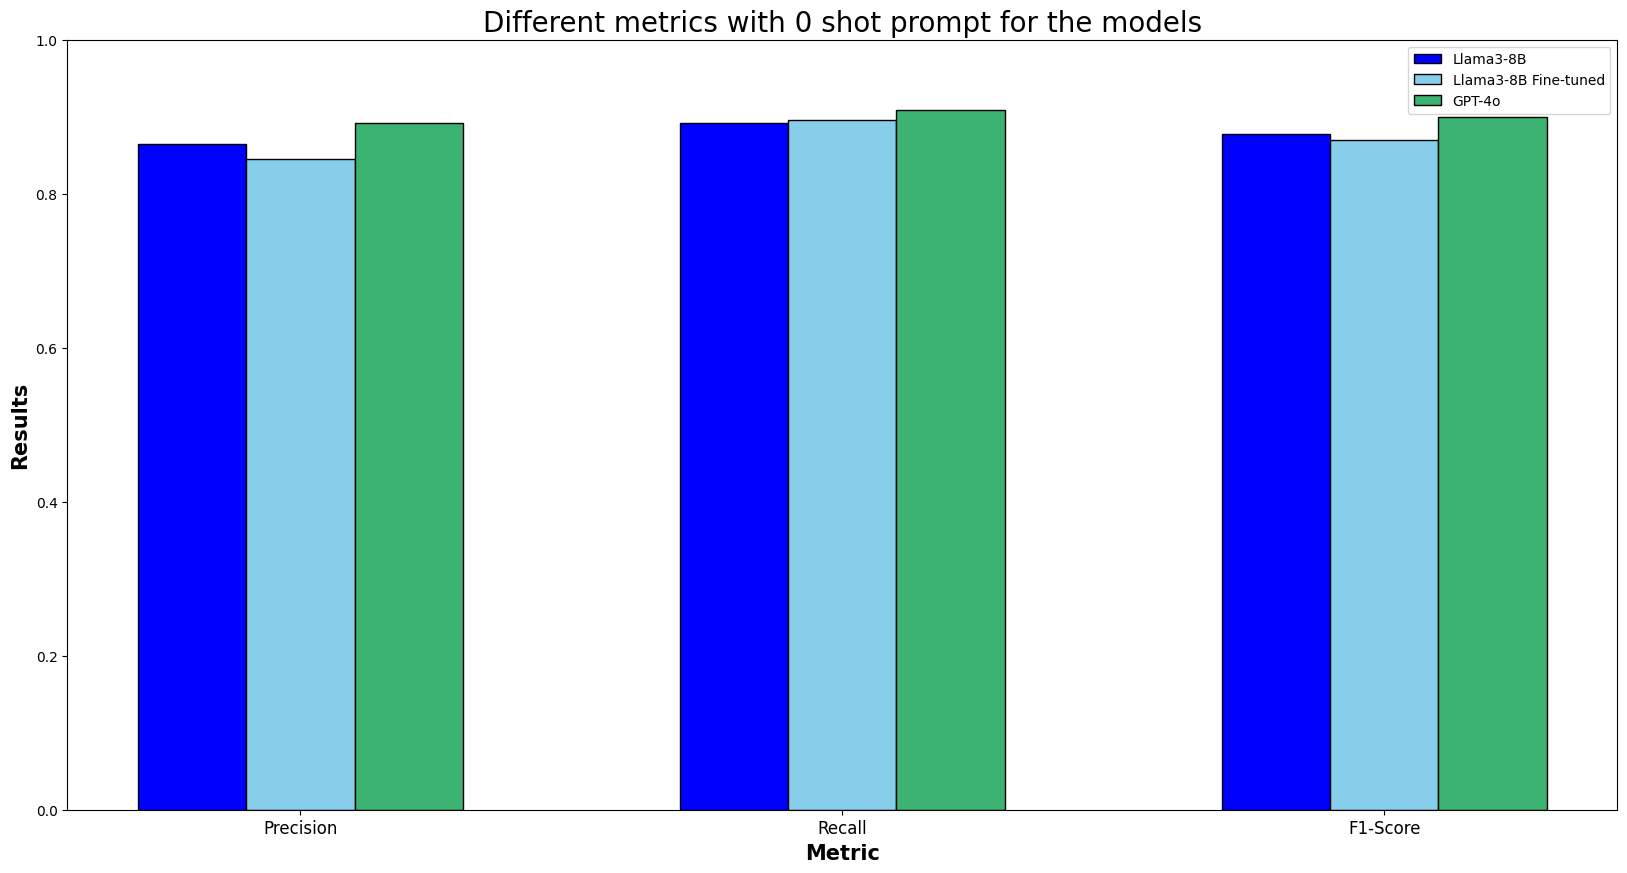

In [40]:
# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize=(20, 10))

plt_models = ["Llama3-8B", "Llama3-8B Fine-tuned", "GPT-4o"]
plt_metrics = ["Precision", "Recall", "F1-Score"]
plt_data = {}
for index, model in enumerate(plt_models):
    plt_data[model] = metrics_0_shot[index]

# Set position of bar on X axis
br1 = np.arange(len(metrics_0_shot[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(
    br1,
    metrics_0_shot[0],
    color="b",
    width=barWidth,
    edgecolor="black",
    label=plt_models[0],
)
plt.bar(
    br2,
    metrics_0_shot[1],
    color="skyblue",
    width=barWidth,
    edgecolor="black",
    label=plt_models[1],
)
plt.bar(
    br3,
    metrics_0_shot[2],
    color="mediumseagreen",
    width=barWidth,
    edgecolor="black",
    label=plt_models[2],
)

# Adding Xticks
plt.xlabel("Metric", fontweight="bold", fontsize=15)
plt.ylabel("Results", fontweight="bold", fontsize=15)
plt.xticks(
    [r + barWidth for r in range(len(metrics_0_shot[0]))], plt_metrics, fontsize=12
)
plt.ylim(0, 1)
plt.title("Different metrics with 0 shot prompt for the models", fontsize=20)

plt.legend()
plt.savefig("bars0.png")
plt.show()

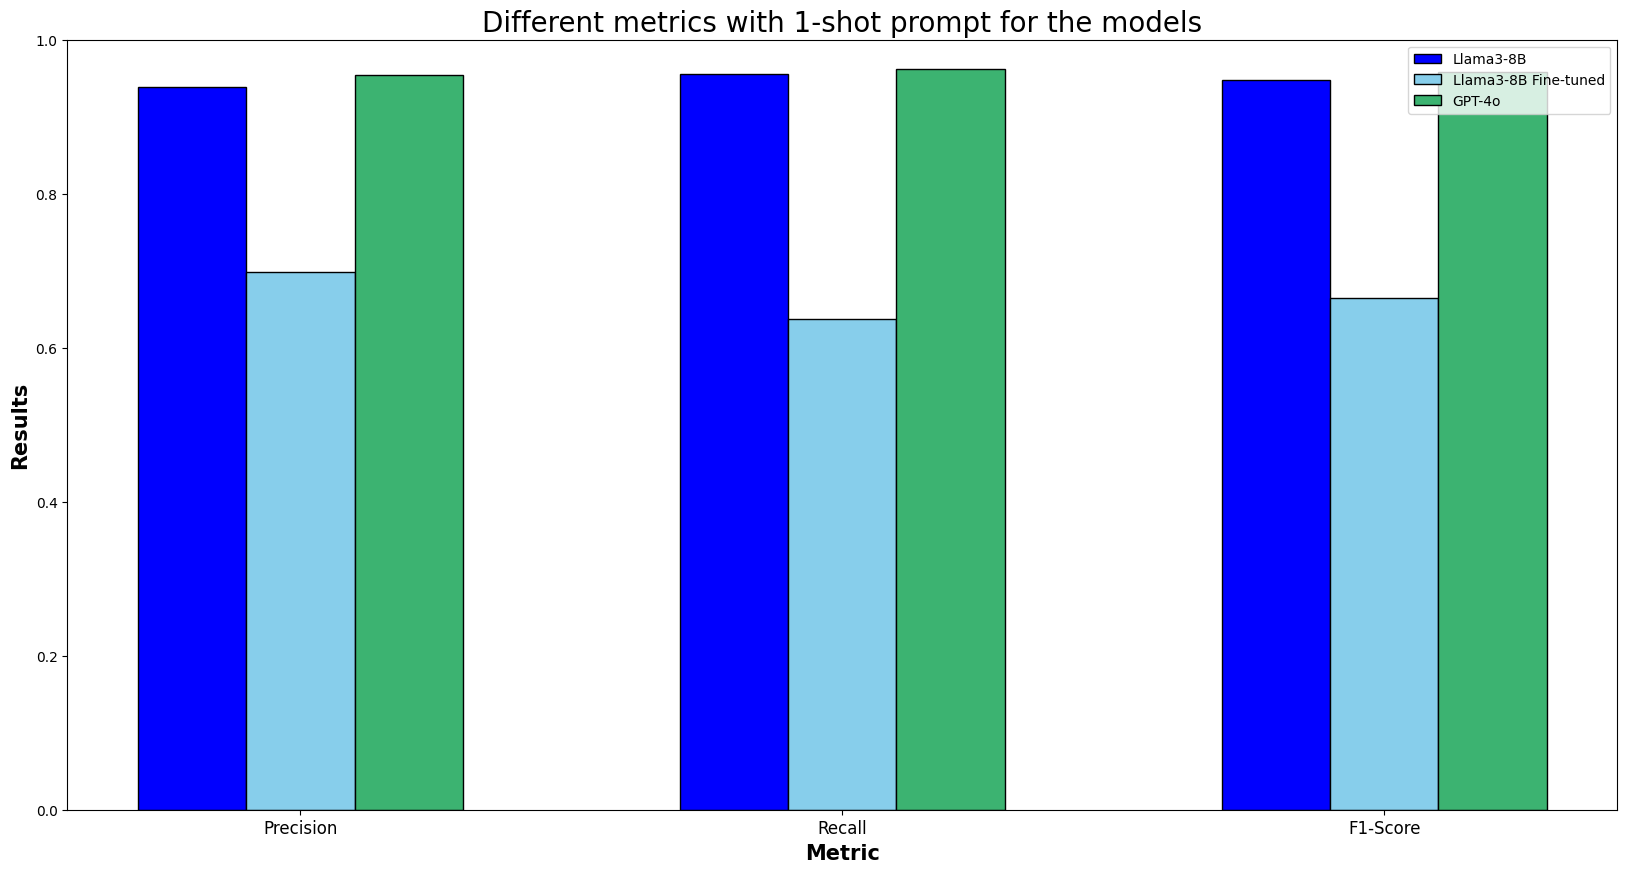

In [41]:
# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize=(20, 10))

plt_data = {}
for index, model in enumerate(plt_models):
    plt_data[model] = metrics_1_shot[index]

# Set position of bar on X axis
br1 = np.arange(len(metrics_1_shot[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(
    br1,
    metrics_1_shot[0],
    color="b",
    width=barWidth,
    edgecolor="black",
    label=plt_models[0],
)
plt.bar(
    br2,
    metrics_1_shot[1],
    color="skyblue",
    width=barWidth,
    edgecolor="black",
    label=plt_models[1],
)
plt.bar(
    br3,
    metrics_1_shot[2],
    color="mediumseagreen",
    width=barWidth,
    edgecolor="black",
    label=plt_models[2],
)

# Adding Xticks
plt.xlabel("Metric", fontweight="bold", fontsize=15)
plt.ylabel("Results", fontweight="bold", fontsize=15)
plt.xticks(
    [r + barWidth for r in range(len(metrics_1_shot[0]))], plt_metrics, fontsize=12
)
plt.ylim(0, 1)
plt.title("Different metrics with 1-shot prompt for the models", fontsize=20)

plt.legend()
plt.savefig("bars1.png")
plt.show()

The results for the three models are quite good, and there are no significant differences between them. This is partly due to the evaluation method used; however, employing a more robust evaluation will lead to more noticeable differences. For this reason, we recommend reviewing the Evaluations section and following the guidelines outlined there.

## References

::: {#refs}
:::
